In [5]:
from mrftools import *

In [3]:
"""Tests for Matrix belief propagation"""
import numpy as np
from mrftools import *
import unittest
import time


class TestMatrixBeliefPropagator(unittest.TestCase):
    """Test class for MatrixBeliefPropagator"""
    def create_chain_model(self):
        """Create chain MRF with variable of different cardinalities."""
        mn = MarkovNet()

        np.random.seed(1)

        k = [4, 3, 6, 2, 5]

        mn.set_unary_factor(0, np.random.randn(k[0]))
        mn.set_unary_factor(1, np.random.randn(k[1]))
        mn.set_unary_factor(2, np.random.randn(k[2]))
        mn.set_unary_factor(3, np.random.randn(k[3]))

        factor4 = np.random.randn(k[4])
        factor4[2] = -float('inf')

        mn.set_unary_factor(4, factor4)

        mn.set_edge_factor((0, 1), np.random.randn(k[0], k[1]))
        mn.set_edge_factor((1, 2), np.random.randn(k[1], k[2]))
        mn.set_edge_factor((2, 3), np.random.randn(k[2], k[3]))
        mn.set_edge_factor((3, 4), np.random.randn(k[3], k[4]))
        mn.create_matrices()

        return mn

    def create_loop_model(self):
        """Create a loop-structured MRF"""
        mn = self.create_chain_model()

        k = [4, 3, 6, 2, 5]

        mn.set_edge_factor((3, 0), np.random.randn(k[3], k[0]))
        mn.create_matrices()
        return mn

    def create_grid_model(self):
        """Create a grid-structured MRF"""
        mn = MarkovNet()

        length = 16

        k = 8

        for x in range(length):
            for y in range(length):
                mn.set_unary_factor((x, y), np.random.random(k))

        for x in range(length - 1):
            for y in range(length):
                mn.set_edge_factor(((x, y), (x + 1, y)), np.random.random((k, k)))
                mn.set_edge_factor(((y, x), (y, x + 1)), np.random.random((k, k)))

        return mn

    def create_grid_model_simple_edges(self):
        """Create a grid-structured MRFs with edge potentials that are attractive."""
        mn = MarkovNet()

        length = 16

        k = 8

        for x in range(length):
            for y in range(length):
                mn.set_unary_factor((x, y), np.random.random(k))

        for x in range(length - 1):
            for y in range(length):
                mn.set_edge_factor(((x, y), (x + 1, y)), np.eye(k))
                mn.set_edge_factor(((y, x), (y, x + 1)), np.eye(k))

        return mn

    def test_exactness(self):
        """Test that Matrix BP produces the true marginals in a chain model."""
        mn = self.create_chain_model()
        bp = MatrixBeliefPropagator(mn)
        bp.infer(display='full')
        bp.load_beliefs()

        bf = BruteForce(mn)

        for i in mn.variables:
            print ("Brute force unary marginal of %d: %s" % (i, repr(bf.unary_marginal(i))))
            print ("Belief prop unary marginal of %d: %s" % (i, repr(np.exp(bp.var_beliefs[i]))))
            assert np.allclose(bf.unary_marginal(i), np.exp(bp.var_beliefs[i])), "beliefs aren't exact on chain model"

        print ("Brute force pairwise marginal: " + repr(bf.pairwise_marginal(0, 1)))
        print ("Belief prop pairwise marginal: " + repr(np.exp(bp.pair_beliefs[(0, 1)])))

        print ("Bethe energy functional: %f" % bp.compute_energy_functional())

        print ("Brute force log partition function: %f" % np.log(bf.compute_z()))

        assert np.allclose(np.log(bf.compute_z()), bp.compute_energy_functional()),\
            "log partition function is not exact on chain model"

    def test_consistency(self):
        """Test that loopy matrix BP infers marginals that are locally consistent."""
        mn = self.create_loop_model()

        bp = MatrixBeliefPropagator(mn)
        bp.infer(display='full')

        bp.load_beliefs()

        for var in mn.variables:
            unary_belief = np.exp(bp.var_beliefs[var])
            for neighbor in mn.get_neighbors(var):
                pair_belief = np.sum(np.exp(bp.pair_beliefs[(var, neighbor)]), 1)
                print(pair_belief, unary_belief)
                assert np.allclose(pair_belief, unary_belief), "unary and pairwise beliefs are inconsistent"

    def test_normalization(self):
        """Test that the unary and pairwise beliefs properly sum to 1.0"""
        mn = self.create_loop_model()

        bp = MatrixBeliefPropagator(mn)
        bp.infer(display='full')

        bp.load_beliefs()

        for var in mn.variables:
            unary_belief = np.exp(bp.var_beliefs[var])
            assert np.allclose(np.sum(unary_belief), 1.0), "unary belief is not normalized"
            for neighbor in mn.get_neighbors(var):
                pair_belief = np.exp(bp.pair_beliefs[(var, neighbor)])
                assert np.allclose(np.sum(pair_belief), 1.0), "pairwise belief is not normalize"

    def test_speedup(self):
        """Test that matrix BP is faster than loop-based BP"""
        mn = self.create_grid_model()

        slow_bp = BeliefPropagator(mn)

        bp = MatrixBeliefPropagator(mn)

        bp.set_max_iter(30000)
        slow_bp.set_max_iter(30000)

        t0 = time.time()
        bp.infer(display='final')
        t1 = time.time()

        bp_time = t1 - t0

        t0 = time.time()
        slow_bp.infer(display='final')
        t1 = time.time()

        slow_bp_time = t1 - t0

        print("Matrix BP took %f, loop-based BP took %f. Speedup was %f" %
              (bp_time, slow_bp_time, slow_bp_time / bp_time))
        assert bp_time < slow_bp_time, "matrix form was slower than loop-based BP"

        # check marginals
        bp.load_beliefs()
        slow_bp.compute_beliefs()
        slow_bp.compute_pairwise_beliefs()

        for var in mn.variables:
            assert np.allclose(bp.var_beliefs[var], slow_bp.var_beliefs[var]), "unary beliefs don't agree"
            for neighbor in mn.get_neighbors(var):
                edge = (var, neighbor)
                assert np.allclose(bp.pair_beliefs[edge], slow_bp.pair_beliefs[edge]), "pairwise beliefs don't agree" \
                           + "\n" + repr(bp.pair_beliefs[edge]) \
                           + "\n" + repr(slow_bp.pair_beliefs[edge])

    def test_conditioning(self):
        """Test that conditioning on variable properly sets variables to conditioned state"""
        mn = self.create_loop_model()

        bp = MatrixBeliefPropagator(mn)

        bp.condition(2, 0)

        bp.infer()
        bp.load_beliefs()

        assert np.allclose(bp.var_beliefs[2][0], 0), "Conditioned variable was not set to correct state"

        beliefs0 = bp.var_beliefs[0]

        bp.condition(2, 1)
        bp.infer()
        bp.load_beliefs()
        beliefs1 = bp.var_beliefs[0]

        assert not np.allclose(beliefs0, beliefs1), "Conditioning var 2 did not change beliefs of var 0"

    def test_overflow(self):
        """Test that MatrixBP does not fail when given very large, poorly scaled factors"""
        mn = self.create_chain_model()

        # set a really large factor
        mn.set_unary_factor(0, [.1, .2, .3, .4])

        mn.create_matrices()

        bp = MatrixBeliefPropagator(mn)

        with np.errstate(all='raise'):
            bp.infer(display='iter')
            bp.load_beliefs()

    def test_grid_consistency(self):
        """Test that matrix BP infers consistent marginals on a grid MRF"""
        mn = self.create_grid_model()
        bp = MatrixBeliefPropagator(mn)
        bp.infer(display='full')

        bp.load_beliefs()

        for var in mn.variables:
            unary_belief = np.exp(bp.var_beliefs[var])
            for neighbor in mn.get_neighbors(var):
                pair_belief = np.sum(np.exp(bp.pair_beliefs[(var, neighbor)]), 1)
                # print pair_belief, unary_belief
                assert np.allclose(pair_belief, unary_belief), "unary and pairwise beliefs are inconsistent"

    def test_belief_propagator_messages(self):
        """Test that matrix BP and loop-based BP calculate the same messages and beliefs each iteration of inference"""
        model = self.create_grid_model_simple_edges()
        bp = BeliefPropagator(model)
        bp.load_beliefs()

        mat_bp = MatrixBeliefPropagator(model)
        mat_bp.load_beliefs()

        for i in range(4):
            for var in sorted(bp.mn.variables):
                for neighbor in sorted(bp.mn.get_neighbors(var)):
                    edge = (var, neighbor)
                    bp_message = bp.messages[edge]

                    if edge in mat_bp.mn.message_index:
                        edge_index = mat_bp.mn.message_index[edge]
                    else:
                        edge_index = mat_bp.mn.message_index[(edge[1], edge[0])] + mat_bp.mn.num_edges

                    mat_bp_message = mat_bp.message_mat[:, edge_index].ravel()

                    assert np.allclose(bp_message, mat_bp_message), \
                        "BP and matBP did not agree on message for edge %s in iter %d" % (repr(edge), i) \
                        + "\nBP: " + repr(bp_message) + "\nmatBP: " + repr(mat_bp_message)

                    # print "Message %s is OK" % repr(edge)

                    assert np.allclose(bp.pair_beliefs[edge], mat_bp.pair_beliefs[edge]), \
                        "BP and matBP did not agree on pair beliefs after %d message updates" % i

                assert np.allclose(bp.var_beliefs[var], mat_bp.var_beliefs[var]), \
                    "BP and matBP did not agree on unary beliefs after %d message updates" % i

            bp.update_messages()
            bp.load_beliefs()
            mat_bp.update_messages()
            mat_bp.load_beliefs()

In [4]:
bp = TestMatrixBeliefPropagator()
bp.test_speedup()

Belief propagation finished in 15 iterations.
Belief propagation finished in 15 iterations.
Matrix BP took 0.066553, loop-based BP took 1.772254. Speedup was 26.629265


In [1]:
from staghunt import StagHuntGame

In [2]:
prova = StagHuntGame()

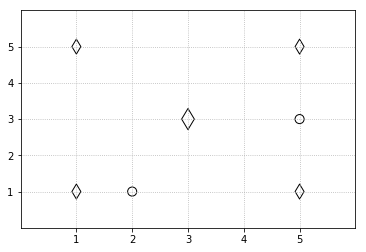

In [3]:
prova.display()

In [2]:
import numpy as np
k = [4, 3, 6, 2, 5]
np.random.randn(k[0])

array([ 0.29325496, -0.58436244, -1.0950592 ,  0.62798496])

In [1]:
from mrftools import MarkovNet

In [3]:
k = [4, 3, 6, 2, 5]

mn = MarkovNet()
mn.declare_variable(0,k[0])
mn.declare_variable(1,k[1])
mn.set_edge_factor((0, 1), np.random.randn(k[0], k[1]))

KeyError: 0

In [20]:
"""Markov network class for storing potential functions and structure."""
import numpy as np
from scipy.sparse import coo_matrix


class MarkovNet(object):
    """Object containing the definition of a pairwise Markov net."""

    def __init__(self):
        """Initialize a Markov net."""
        self.edge_potentials = dict()
        self.unary_potentials = dict()
        self.neighbors = dict()
        self.variables = set()
        self.num_states = dict()
        self.matrix_mode = False
        self.tree_probabilities = dict()

        # initialize values only used in matrix mode to None
        self.max_states = None
        self.message_to_map = None
        self.message_to = None
        self.message_from = None
        self.var_index = None
        self.var_list = None
        self.unary_mat = None
        self.edge_pot_tensor = None
        self.num_edges = None
        self.message_index = None
        self.degrees = None

    def set_unary_factor(self, variable, potential):
        """
        Set the potential function for the unary factor. Implicitly declare variable. 
        Must be called before setting edge factors.
        
        :param variable: name of the variable (can be any hashable object)
        :param potential: length-k vector of log potential values for the respective k states
        :return: None
        """
        self.unary_potentials[variable] = potential
        if variable not in self.variables:
            self.declare_variable(variable, np.size(potential))

    def declare_variable(self, variable, num_states):
        """
        Indicate the existence of a variable
        
        :param variable: name of the variable (can be any hashable object)
        :param num_states: integer number of states the variable can take
        :return: None
        """
        if variable not in self.variables:
            self.variables.add(variable)
            self.neighbors[variable] = set()
            self.num_states[variable] = num_states
        else:
            print("Warning: declaring a variable %s that was previously declared." % repr(variable))

    def set_edge_factor(self, edge, potential):
        """
        Set a factor by inputting the involved variables then the potential function. 
        The potential function should be a np matrix.

        :param edge: 2-tuple of the variables in the edge. Can be in any order.
        :param potential: k1 by k2 matrix of potential values for the joint state of the two variables
        :return: None
        """
        print(np.shape(potential))
        assert np.shape(potential) == (len(self.unary_potentials[edge[0]]), len(self.unary_potentials[edge[1]])), \
            "potential size %d, %d incompatible with unary sizes %d, %d" % \
            (np.shape(potential)[0], np.shape(potential)[1], len(self.unary_potentials[edge[0]]),
             len(self.unary_potentials[edge[1]]))

        if edge[0] < edge[1]:
            self.edge_potentials[edge] = potential
        else:
            self.edge_potentials[(edge[1], edge[0])] = potential.T

        self.neighbors[edge[0]].add(edge[1])
        self.neighbors[edge[1]].add(edge[0])

In [1]:
k = [4, 3, 6, 2, 5]

mn = MarkovNet()
mn.set_unary_factor('x11', 25*[0])
mn.set_unary_factor('x12', 25*[0])
mn.set_edge_factor(('x11', 'x12'), np.random.randn(25, 25))

NameError: name 'MarkovNet' is not defined

In [1]:
import numpy as np
from staghunt import StagHuntGame

In [2]:
caca = StagHuntGame()

In [3]:
caca.build_model()

0 0 12
1 0 12
0 1 12
1 1 12
0 2 12
1 2 12
0 3 12
1 3 12
0 4 12
1 4 12
0 5 12
1 5 12
0 6 12
1 6 12
0 7 12
1 7 12
0 8 12
1 8 12
0 9 12
1 9 12
0 10 12
1 10 12
0 11 12
1 11 12
0 12 12
1 12 12
0 13 12
1 13 12
0 14 12
1 14 12
0 15 12
1 15 12
0 16 12
1 16 12
0 17 12
1 17 12
0 18 12
1 18 12
0 19 12
1 19 12
0 20 12
1 20 12
0 21 12
1 21 12
0 22 12
1 22 12
0 23 12
1 23 12
0 24 12
1 24 12
0 0 12
1 0 12
0 1 12
1 1 12
0 2 12
1 2 12
0 3 12
1 3 12
0 4 12
1 4 12
0 5 12
1 5 12
0 6 12
1 6 12
0 7 12
1 7 12
0 8 12
1 8 12
0 9 12
1 9 12
0 10 12
1 10 12
0 11 12
1 11 12
0 12 12
1 12 12
0 13 12
1 13 12
0 14 12
1 14 12
0 15 12
1 15 12
0 16 12
1 16 12
0 17 12
1 17 12
0 18 12
1 18 12
0 19 12
1 19 12
0 20 12
1 20 12
0 21 12
1 21 12
0 22 12
1 22 12
0 23 12
1 23 12
0 24 12
1 24 12


In [6]:
caca.markov_net.edge_potentials

{('x11',
  'x21'): array([[1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0

In [52]:
mn = MarkovNet()

np.random.seed(1)

k = [4, 3, 6, 2, 5]

mn.set_unary_factor(0, np.random.randn(k[0]))
mn.set_unary_factor(1, np.random.randn(k[1]))
mn.set_unary_factor(2, np.random.randn(k[2]))
mn.set_unary_factor(3, np.random.randn(k[3]))

factor4 = np.random.randn(k[4])
factor4[2] = -float('inf')

mn.set_unary_factor(4, factor4)

mn.set_edge_factor((0, 1), np.random.randn(k[0], k[1]))
mn.set_edge_factor((1, 2), np.random.randn(k[1], k[2]))
mn.set_edge_factor((2, 3), np.random.randn(k[2], k[3]))
mn.set_edge_factor((3, 4), np.random.randn(k[3], k[4]))

In [56]:
mn.unary_potentials

{0: array([ 0.16003707,  0.87616892,  0.31563495, -2.02220122]),
 1: array([ 0.86540763, -2.3015387 ,  1.74481176]),
 2: array([-0.7612069 ,  0.3190391 , -0.24937038,  1.46210794, -2.06014071,
        -0.3224172 ]),
 3: array([-0.38405435,  1.13376944]),
 4: array([-1.09989127, -0.17242821,        -inf,  0.04221375,  0.58281521])}

In [55]:
mn.set_unary_factor(0, np.random.randn(k[0]))

In [12]:
agent_index = 1
stag_index = 1
var_key = 'd' + str(agent_index) + str(stag_index)

In [15]:
k = [4, 3, 6, 2, 5]
np.random.randn(k[0], k[1])

array([[-0.25586242,  0.18876714, -0.89756783],
       [-0.64972053,  0.97595561, -0.49482713],
       [ 1.01370793,  0.23540329,  0.32133393],
       [-0.91223975, -0.42969196,  1.57956671]])

In [27]:
uep[1,2]

0.0

In [26]:
uep.shape[0]

2